# Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('/cvmfs/icecube.opensciencegrid.org/py3-v4.3.0/RHEL_7_x86_64/lib/python3.11/site-packages/')
import photospline
from photospline import glam_fit, ndsparse, bspline

import site
sys.path.append(site.USER_SITE)
import uproot
from scipy.interpolate import interp1d
import healpy as hp
import glob

# HAWC - Loading and reading in the data

In [2]:
elements = ["proton", "helium", "carbon", "oxygen", "neon", "magnesium", "silicon", "iron"]

files = sorted(glob.glob("pass5.1/*.root"))

main_dict = {e: {} for e in elements}

for e in elements:
    data_candidates = [file for file in files if (e in file) and ('mc' not in file)]
    weight_candidates = [file for file in files if (e in file) and ('mc' in file)]

    # reading the data files
    if len(data_candidates) == 1:
        data_file = data_candidates[0]
        with uproot.open(data_file) as f:
            t = f["XCDF"]
            main_dict[e]["nChAvail"] = t["rec.nChAvail"].array(library="np")
            main_dict[e]["nHit"]      = t["rec.nHit"].array(library="np")
            main_dict[e]["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np")
            main_dict[e]["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
            main_dict[e]["zenith"]   = t["rec.zenithAngle"].array(library="np")
            main_dict[e]["coreX"]    = t["rec.coreX"].array(library="np")
            main_dict[e]["coreY"]    = t["rec.coreY"].array(library="np")
            main_dict[e]["coreR"] = np.sqrt((main_dict[e]["coreX"]-37.19)**2+(main_dict[e]["coreY"]-246)**2)/100.
            main_dict[e]["pinc"]     = t["rec.PINC"].array(library="np")
            main_dict[e]["trueEnergy"] = t["mc.logEnergy"].array(library="np")
            # t.show()

    # read the weights files
    if len(weight_candidates) ==1:
        weight_file = weight_candidates[0]
        with uproot.open(weight_file) as f:
            t = f["XCDF"]
            main_dict[e]["gsf"] = t["sweets.IWgt.gsf"].array(library="np")
            main_dict[e]["h3a"] = t["sweets.IWgt.h3a"].array(library="np")

    # defining the initial cuts
    initial_cut = np.logical_and(main_dict[e]["nHit"] > 75, main_dict[e]["zenith"] >= 0)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["zenith"] < 1.222)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["CxPE40XnCh"] > 40)

    # applied the initial cuts here to all the arrays
    for key in main_dict[e].keys():
        main_dict[e][key] = main_dict[e][key][initial_cut]

In [3]:
main_dict

{'proton': {'nChAvail': array([1066,  999, 1074, ..., 1063, 1070,  988], dtype=uint64),
  'nHit': array([333, 998,  86, ..., 235, 110, 976], dtype=uint64),
  'CxPE40XnCh': array([ 99, 211,  65, ..., 112,  57, 135], dtype=uint64),
  'corsikaParticleId': array([14, 14, 14, ..., 14, 14, 14], dtype=uint64),
  'zenith': array([0.1919, 0.2421, 0.0982, ..., 0.727 , 0.8772, 0.0877]),
  'coreX': array([73.4, 29.9, 97.5, ..., 94. , 35.6, 99.1]),
  'coreY': array([176.3, 246.7, 276.2, ..., 255. , 179.8, 262.6]),
  'coreR': array([0.78544599, 0.07323531, 0.67448766, ..., 0.57518485, 0.66219092,
         0.64096865]),
  'pinc': array([3.09, 2.43, 1.46, ..., 1.74, 0.81, 2.37]),
  'trueEnergy': array([3.592, 5.111, 2.494, ..., 3.657, 3.863, 5.075]),
  'gsf': array([1.03459167e-03, 6.58024165e-05, 8.19134620e-04, ...,
         9.65951095e-05, 1.05589482e-03, 1.33738021e-05]),
  'h3a': array([1.05252091e-03, 6.69624836e-05, 8.06668809e-04, ...,
         9.69478026e-05, 1.02743641e-03, 1.36929351e-05])}

In [43]:
# zenith, nHit, nChAvail, coreR, true energy, corsikaParticleID, pinc, gsf, h3a

zenith, nHit, nChAvail, coreR, log_true_E, particleId, pinc, gsf, h3a = [], [], [], [], [], [], [], [], []

for e in main_dict.keys():
    zenith.append(main_dict[e]["zenith"])
    nHit.append(main_dict[e]["nHit"])
    nChAvail.append(main_dict[e]["nChAvail"])
    coreR.append(main_dict[e]["coreR"])
    log_true_E.append(main_dict[e]["trueEnergy"])
    particleId.append(main_dict[e]["corsikaParticleId"])
    pinc.append(main_dict[e]["pinc"])
    gsf.append(main_dict[e]["gsf"])
    h3a.append(main_dict[e]["h3a"])

zenith = np.concatenate(zenith)
nHit = np.concatenate(nHit)
nChAvail = np.concatenate(nChAvail)
coreR = np.concatenate(coreR)
log_true_E = np.concatenate(log_true_E)
particleId = np.concatenate(particleId)
pinc = np.concatenate(pinc)
gsf = np.concatenate(gsf)
h3a = np.concatenate(h3a)

# HAWC - Calculate the reco energy

In [44]:
def get_reco_energy(zenith, nHit, nChAvail, coreR):
    tab1 = photospline.SplineTable(f'pass5_spline_combined3d.fits')
    x = np.cos(zenith)
    y = nHit/nChAvail
    z = coreR

    reco_energy = []

    for i in range(x.size):
        coord3d = [x[i], y[i], z[i]]
        try:
            centers = tab1.search_centers(coord3d)
            reco_energy.append(tab1.evaluate(coord3d, centers))
        except:
            reco_energy.append(-1)

    reco_energy = np.array(reco_energy)

    return reco_energy

In [45]:
reco_energy = get_reco_energy(zenith, nHit, nChAvail, coreR)

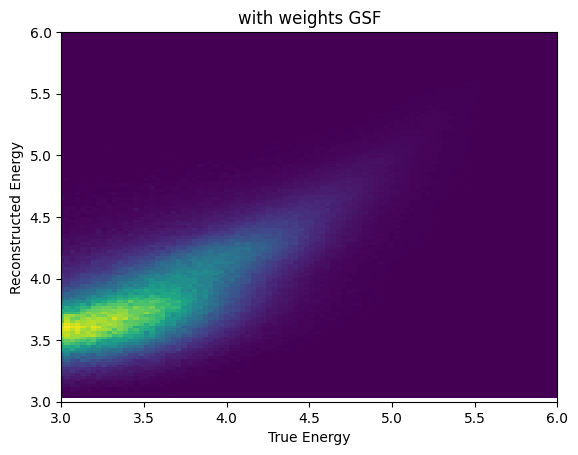

In [46]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = gsf)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

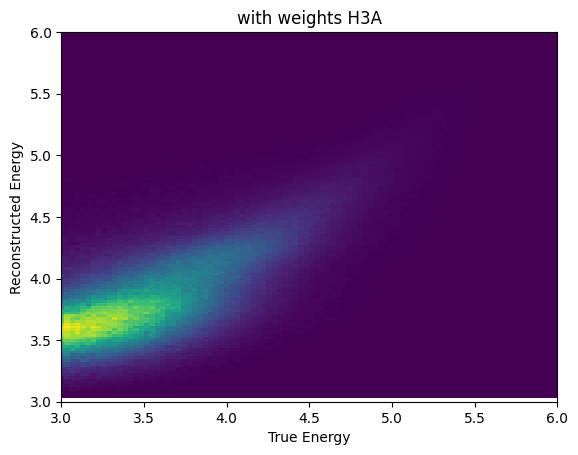

In [47]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = h3a)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights H3A')
plt.show()

# HAWC - Converting particle IDs to atomic numbers

In [48]:
particle_ids = {14: 1, 402 : 2, 1206 : 6, 2412: 12, 2010 : 10, 1608: 8, 2814: 14, 5626: 26}

In [49]:
atomic_number = []
for i in particleId:
    atomic_number.append(particle_ids[i])

atomic_number = np.array(atomic_number)

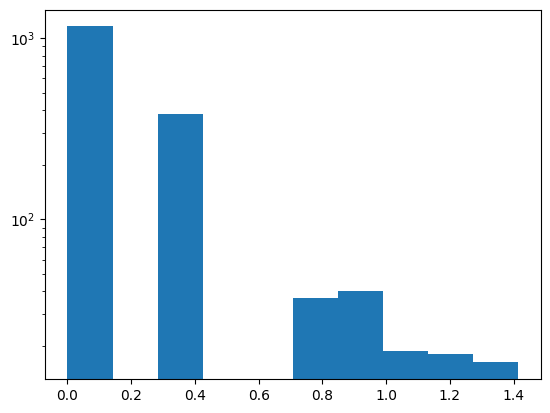

In [50]:
plt.hist(np.log10(atomic_number), weights = gsf)
plt.yscale('log')
plt.show()

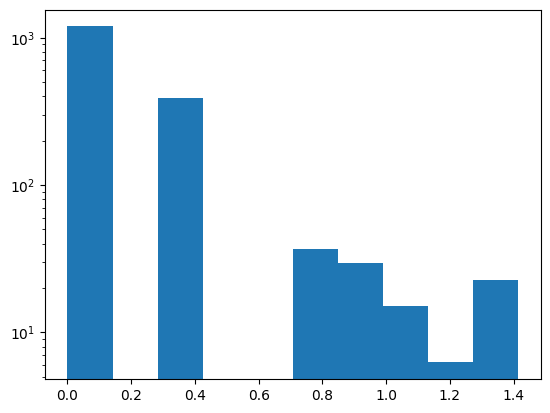

In [51]:
plt.hist(np.log10(atomic_number), weights = h3a)
plt.yscale('log')
plt.show()

In [52]:
# mean_logz = np.average(np.log10(atomic_number), weights = weights)
# mean_logz

# HAWC - Energy cuts on reco energy applied to true energy

- 12 total cuts going from bin0 to bin11

In [53]:
min_energies = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0]
max_energies = [3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.98, 5.15, 5.44, 5.68, 6.0, 6.9]
pinc_vals = [1.3, 1.4, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [54]:
def cut_energy(min_energy, max_energy, pinc_val):
    cut = np.logical_and(min_energy <= reco_energy, max_energy > reco_energy)
    cut = np.logical_and(cut, pinc > pinc_val)

    return cut

In [55]:
cuts = []

for i , j , k in zip(min_energies, max_energies, pinc_vals):
    cut = cut_energy(i, j , k)
    cuts.append(cut)

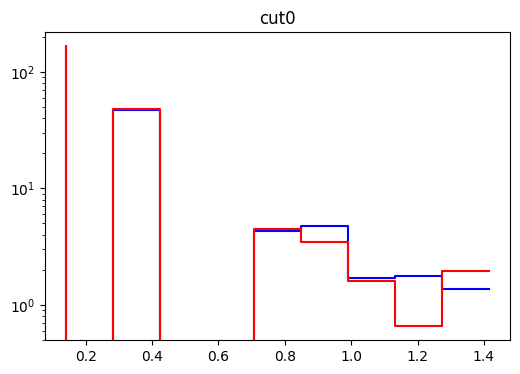

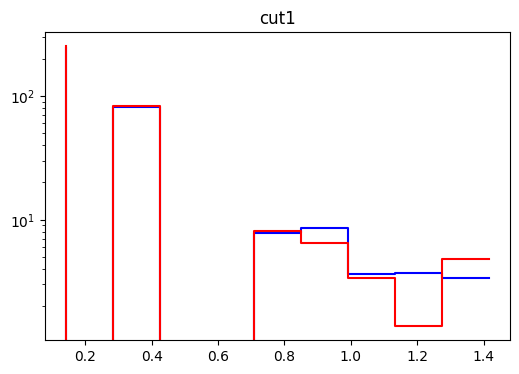

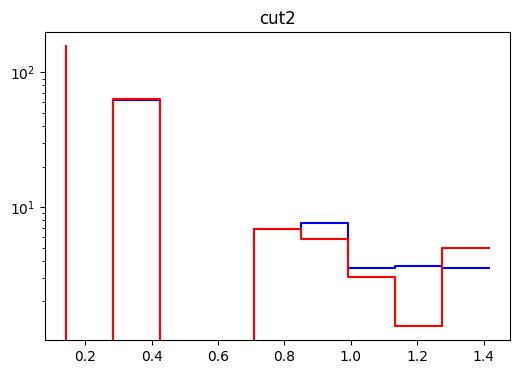

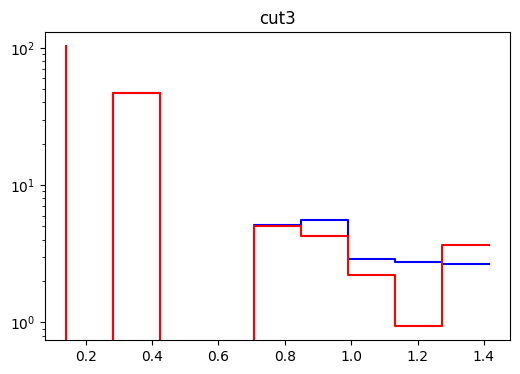

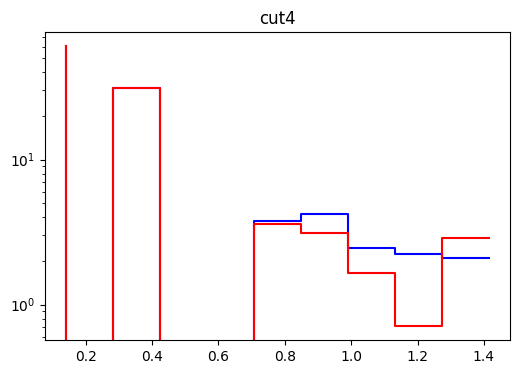

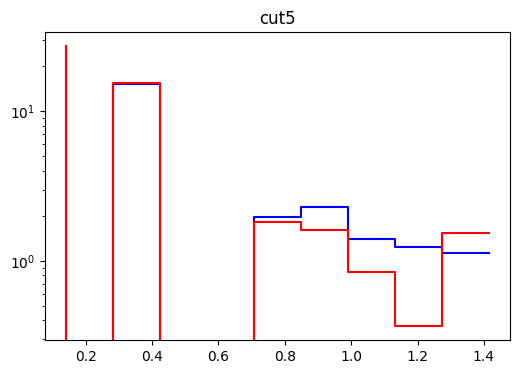

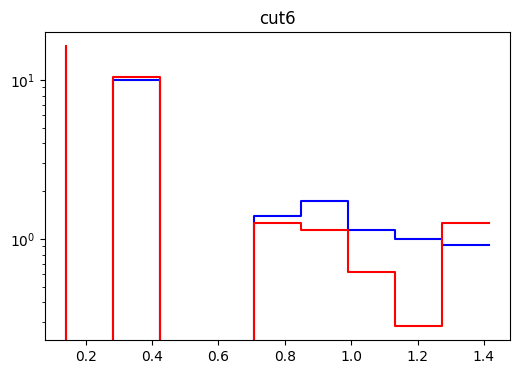

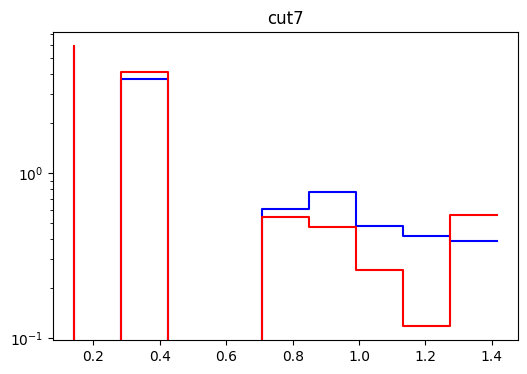

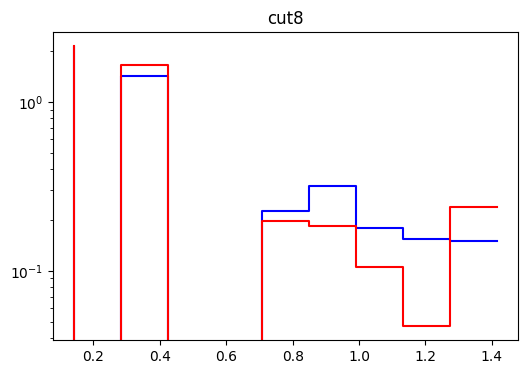

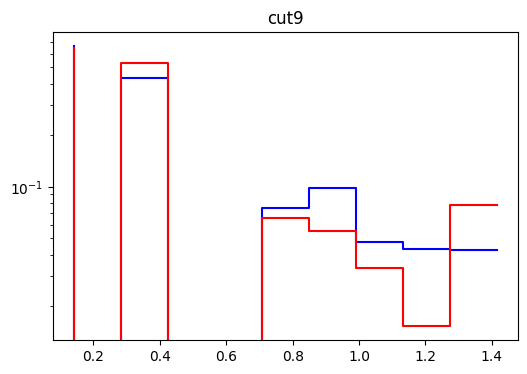

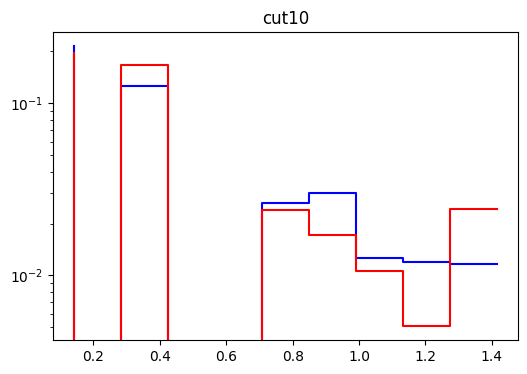

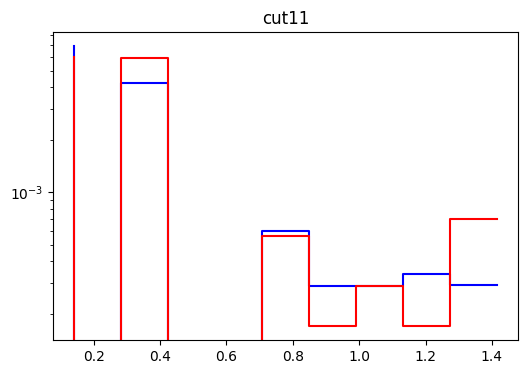

In [60]:
mean_energies_gsf = []
mean_energies_h3a = []
mean_atomic_gsf = []
mean_atomic_h3a = []

for i, cut in enumerate(cuts):
    mean_energy_gsf = np.average(log_true_E[cut], weights = gsf[cut])
    mean_energy_h3a = np.average(log_true_E[cut], weights = h3a[cut])
    mean_logz_gsf = np.average(np.log10(atomic_number[cut]), weights = gsf[cut])
    mean_logz_h3a = np.average(np.log10(atomic_number[cut]), weights = h3a[cut])

    mean_energies_gsf.append(mean_energy_gsf)
    mean_energies_h3a.append(mean_energy_h3a)
    mean_atomic_gsf.append(mean_logz_gsf)
    mean_atomic_h3a.append(mean_logz_h3a)

    bin_gsf, edge_gsf = np.histogram(np.log10(atomic_number[cut]), weights = gsf[cut])
    bin_h3a, edge_h3a = np.histogram(np.log10(atomic_number[cut]), weights = h3a[cut])
    plt.figure(figsize = (6, 4))
    plt.step(edge_gsf[1:], bin_gsf, 'b')
    plt.step(edge_h3a[1:], bin_h3a, 'r')
    plt.yscale('log')
    plt.title(f"cut{i}")
    plt.show()

mean_energies_gsf = np.array(mean_energies_gsf)
mean_energies_h3a = np.array(mean_energies_h3a)
mean_atomic_gsf = np.array(mean_atomic_gsf)
mean_atomic_h3a = np.array(mean_atomic_h3a)

In [61]:
total_n_gsf, total_edges_gsf = np.histogram(log_true_E, bins = mean_energies_gsf, weights = gsf)
total_n_h3a, total_edges_h3a = np.histogram(log_true_E, bins = mean_energies_h3a, weights = h3a)

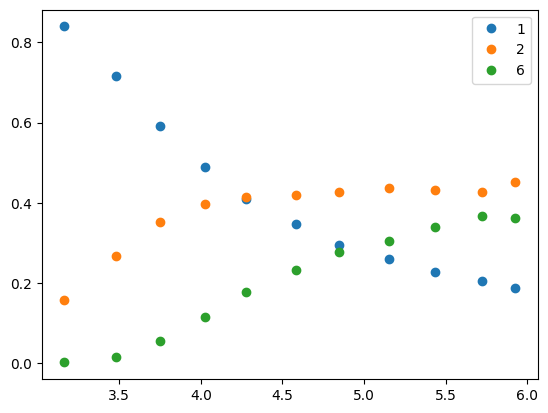

In [74]:
# for i in np.unique(atomic_number):
# gsf
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies, weights = weights[atomic_number >= i])
    else:
        ni, ei = np.histogram(true_log_E[atomic_number == i], bins = mean_energies, weights = weights[atomic_number == i])

    frac = ni/total_n
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("gsf")
plt.legend()

In [37]:
mean_rid = mean_energies - mean_atomic

In [38]:
mean_rid

array([2.81319335, 3.03805136, 3.31701688, 3.56938584, 3.81972972,
       4.04497774, 4.321194  , 4.55818786, 4.8450964 , 5.10989772,
       5.38700835, 5.62348182])

In [34]:
mean_energies

array([2.91869148, 3.16320496, 3.47792446, 3.74814745, 4.02750556,
       4.27486114, 4.58400455, 4.84669774, 5.15354203, 5.43174198,
       5.71936078, 5.9254539 ])

In [35]:
mean_atomic

array([0.10549812, 0.1251536 , 0.16090758, 0.1787616 , 0.20777584,
       0.2298834 , 0.26281055, 0.28850988, 0.30844563, 0.32184426,
       0.33235244, 0.30197208])

In [39]:
print(np.power(10, mean_atomic))

[1.27496459 1.33399316 1.44846359 1.50925146 1.61352552 1.69778779
 1.8315153  1.94316591 2.03444349 2.09818732 2.14957418 2.00434315]


# IceCube - Reading and viewing the files

- nchannel: number of active channels
- llhZen: reconstructed zenith
- llhAz: reconstructed azimuth
- zenith: zenith angle
- azimuth: azimuth angle
- mc_energy: true energy
- type: proton, helium, nitrogen, aluminium, iron
- isgoodllh: 
- ndir: 
- ldir:
- rlogl:
- atmosphere:
- TriggID_1006:
- energy: true energy
- GaisserH3a: weights
- Hoerandel: weights
- GlobalFitGST: weights
- reco_energy: reconstructed energy

In [28]:
dst = np.load('dst_20904_v2.npz')

print(dst.files)

# accessing individual numpy arrays from the file
# dst['zenith']

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'reco_energy']


[4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]

bin edges in log for the reco energy

# IceCube - Applying initial cuts

In [29]:
imain_cut = np.logical_and(dst['nchannel'] > 10, dst['llhZen'] < 70)

ienergy = np.log10(dst['energy'][imain_cut])
weights_1 = dst['GaisserH3a'][imain_cut]
weights_2 = dst['Hoerandel'][imain_cut]
weights_3 = dst['GlobalSplineFit5Comp'][imain_cut]
ireco_energy = dst['reco_energy'][imain_cut]
inchannel = dst['nchannel'][imain_cut]
ireco_zenith = dst['llhZen'][imain_cut]
izenith = dst['zenith'][imain_cut]
itype = dst['type'][imain_cut]

iparticle_ids = {2212: 1, 1000020040: 2, 1000070140: 7, 1000130270: 13, 1000260560: 26}

In [93]:
iatomic = []
for i in itype:
    iatomic.append(iparticle_ids[i])

iatomic = np.array(iatomic)

# IceCube - Binning the data

In [94]:
total_n1, total_edges1 = np.histogram(ienergy, bins = mean_energies, weights = weights_1)

In [95]:
total_n1

array([ 12.12368192, 104.14372664, 192.78529264, 266.47508842,
       249.00749389, 277.7663161 , 179.9252215 , 141.11813439,
        73.86868815,  38.40996531,  12.94263083])

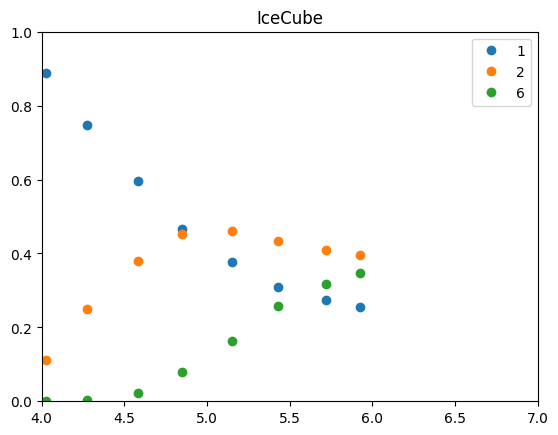

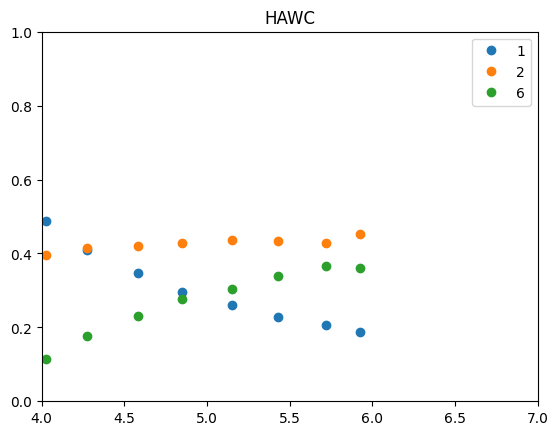

In [85]:
for i in [1, 2, 6]:
    if i >= 6:
        ni, ei = np.histogram(ienergy[iatomic >= i], bins = mean_energies, weights = weights_1[iatomic >= i])
    else:
        ni, ei = np.histogram(ienergy[iatomic == i], bins = mean_energies, weights = weights_1[iatomic == i])
    
    # ni, ei = np.histogram(ienergy[iatomic == i], bins = imean_energies, weights = weights_1[iatomic == i])
    frac = ni/total_n1
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.legend()
plt.title("IceCube")
plt.xlim(4, 7)
plt.ylim(0, 1)
plt.show()

for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(true_log_E[atomic_number >= i], bins = mean_energies, weights = weights[atomic_number >= i])
    else:
        ni, ei = np.histogram(true_log_E[atomic_number == i], bins = mean_energies, weights = weights[atomic_number == i])

    frac = ni/total_n
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.legend()
plt.title("HAWC")
plt.xlim(4, 7)
plt.ylim(0, 1)
plt.show()

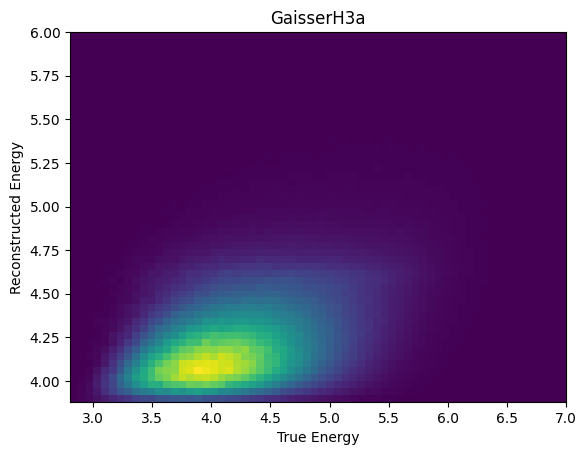

In [45]:
# GaisserH3a
plt.hist2d(ienergy, ireco_energy, bins = 100, weights = weights_1)
plt.ylim(top = 6)
plt.xlim(right = 7)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('GaisserH3a')
plt.show()

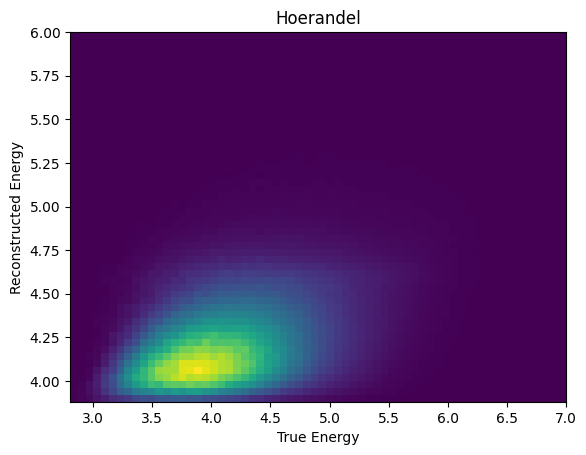

In [46]:
# Hoerandel
plt.hist2d(ienergy, ireco_energy, bins = 100, weights = weights_2)
plt.ylim(top = 6)
plt.xlim(right = 7)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('Hoerandel')
plt.show()

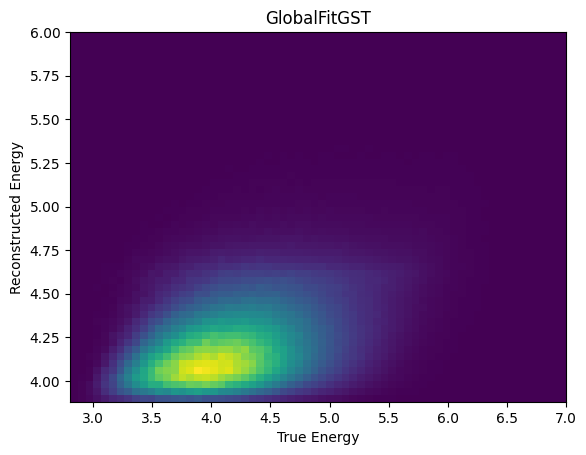

In [47]:
# GlobalFitGST
plt.hist2d(ienergy, ireco_energy, bins = 100, weights = weights_3)
plt.ylim(top = 6)
plt.xlim(right = 7)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('GlobalFitGST')
plt.show()

In [48]:
imean_energies = []
imean_atomics = []

bins = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0, 6.9]

for i in range(len(bins) - 1):
    cut = np.logical_and(ireco_energy >= bins[i], ireco_energy < bins[i + 1])

    mean_energy1 = np.average(ienergy[cut], weights = weights_1[cut])
    mean_energy2 = np.average(ienergy[cut], weights = weights_2[cut])
    mean_energy3 = np.average(ienergy[cut], weights = weights_3[cut])

    mean_atomic1 = np.average(iatomic[cut], weights = weights_1[cut])
    mean_atomic2 = np.average(iatomic[cut], weights = weights_2[cut])
    mean_atomic3 = np.average(iatomic[cut], weights = weights_3[cut])

    imean_energies.append(mean_energy1)
    imean_atomics.append(mean_atomic1)

imean_energies = np.array(imean_energies)
imean_atomics = np.log10(np.array(imean_atomics))

In [49]:
imean_rid = imean_energies - imean_atomics
imean_rid

array([3.92876884, 4.12207017, 4.28224312, 4.43575428, 4.59410073,
       4.73784537, 4.91543435, 5.25024173])

In [79]:
imean_atomics

array([0.22637523, 0.26344283, 0.33016203, 0.39912349, 0.48662633,
       0.57689197, 0.69899457, 0.87103317])

In [80]:
imean_energies

array([4.15514407, 4.385513  , 4.61240515, 4.83487776, 5.08072706,
       5.31473735, 5.61442892, 6.1212749 ])

- gsf: same weight as the gst in icecube
- h3a: gaisser weight in icecube
- new: -